In [1]:
from models.nn_model_v2 import check_all_attr, dataload_preprocessing
from models.nn_model_v2 import Net, Edu_Data
from models.nn_model_v2 import criterion
from models.nn_model_v2 import train, validate, test,test_various_metric, best_validation_loss
from models.nn_model_v2 import show_data,plot_decision_regions_2class
import time, torch

# import torch
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

# conda install pytorch torchvision -c pytorch
# pip install torchinfo


### 변경해볼만한 변수들
##### non_use_attr: 주어진 데이터셋에서 학습에 활용하지 않을 설명변수명을 입력 -> 설명변수 조건 다양화, 성능과 큰 관련을 갖는 설명변수를 찾을 수 있음.
##### epochs: 모델이 전체 데이터셋을 학습하는 횟수 -> 큰 값으로 설정할수록 훈련시간 증가
##### batch_size: 모델이 학습할때 한번에 모든 데이터를 학습하는게 아니라, 분할해 학습하게 됩니다. 이때 분할의 유닛사이즈를 의미합니다. -> 값이 작을수록 세밀하게 데이터를 학습할 수 있지만, 세밀한 학습이 정확도 향상을 항상 보장하진 않습니다.
##### optimizer: 모델의 추론 오류를 개선(반영)하는 방식 -> 다른 훈련파라미터들과 함께 조합해 사용. SGD, ADAM, AdaDelta 가 일반적으로 좋은 성능을 냄

In [2]:
# data loading and preprocessing
check_all_attr() # 주석을 해제해 모든 데이터 특성이름을 확인하세요.


==Data attributes included==
  1 ~  5 |  'female' , 'black' , 'hisp' , 'asian' , 'other'
  6 ~ 10 |  'age' , 'agesq' , 'g11ses' , 'g9ses' , 'g11math'
 11 ~ 15 |  'g9math' , 'hs_par' , 'lfaminc0811' , 'twoparguar' , 'singlepar'
 16 ~ 20 |  'lesshalf' , 'g9nonnative' , 'g9partalkclg' , 'g9schtalkclg' , 'g11catholic'
 21 ~ 25 |  'g11otherprivate' , 'g9catholic' , 'g9otherprivate' , 'g11city' , 'g11suburb'
 26 ~ 30 |  'g11town' , 'g11northeast' , 'g11midwest' , 'g11south' , 'g9city'
 31 ~ 35 |  'g9suburb' , 'g9town' , 'g9northeast' , 'g9midwest' , 'g9south'
 36 ~ 40 |  'm_s2controlsborn_yes' , 's2mcontrolsborn_yes' , 'm_s2controlsstoptrying_yes' , 's2mcontrolsstoptrying_yes' , 'm_s2controlschallenge_yes'
 41 ~ 45 |  's2mcontrolschallenge_yes' , 'repeatg9' , 'high_sci_nosci' , 'high_sci_gensci' , 'high_sci_spesci'
 46 ~ 50 |  'high_sci_advsci' , 'high_sci_apib' , 'exp9ed_dontknow' , 'exp9ed_hs' , 'exp9ed_aa'
 51 ~ 55 |  'exp9ed_ba' , 'exp9ed_grad' , 'exp11ed_hsbroad' , 'exp11ed_aa' , 'exp1

In [3]:

non_use_attr =['age','agesq']
# non_use_attr = [
#     'g11ses' , 'g9ses' , 'g11math',
#     'g9math' , 'hs_par' , 'lfaminc0811' , 'twoparguar' , 'singlepar',
#     'lesshalf' , 'g9nonnative' , 'g9partalkclg' , 'g9schtalkclg' , 'g11catholic',
#     'g11otherprivate' , 'g9catholic' , 'g9otherprivate' , 'g11city' , 'g11suburb',
#     'g11town' , 'g11northeast' , 'g11midwest' , 'g11south' , 'g9city',
#     'g9suburb' , 'g9town' , 'g9northeast' , 'g9midwest' , 'g9south',
#     'm_s2controlsborn_yes' , 's2mcontrolsborn_yes' , 'm_s2controlsstoptrying_yes' , 's2mcontrolsstoptrying_yes' , 'm_s2controlschallenge_yes' ,      
#     's2mcontrolschallenge_yes' , 'repeatg9' , 'high_sci_nosci' , 'high_sci_gensci' , 'high_sci_spesci',
#     'high_sci_advsci' , 'high_sci_apib' , 'exp9ed_dontknow' , 'exp9ed_hs' , 'exp9ed_aa',
#     'exp9ed_ba' , 'exp9ed_grad' , 'exp11ed_hsbroad' , 'exp11ed_aa' , 'exp11ed_ba',
#     'exp11ed_grad' , 'req_ed_occ09_notknow' , 'reqed_occ09_hs' , 'reqed_occ09_aa' , 'reqed_occ09_ba',
#     'reqed_occ09_grad' , 'req_ed_occ12_notknow' , 'reqed_occ12_hs' , 'reqed_occ12_aa' , 'reqed_occ12_ba',
#     'reqed_occ12_grad']
X, y = dataload_preprocessing(non_use_attr)


Number of data attributes:  66
2  data attributes are removed.
Number of data attributes in Traing/Testing process:  64


# Dataset Preparation for Training/Testing

In [4]:
batch_size = 32

data_set = Edu_Data(X,y)
train_size = int(len(X) * 0.7)
val_size = int(train_size * 0.15)
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data_set, lengths=[train_size, val_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Model Params Declaration

##### Model Params

In [5]:
input_dim = len(X.columns)
hidden_dim = 512
dropout_r = 0.2
output_dim = 2
model = Net(input_dim, hidden_dim, output_dim, dropout=dropout_r)

##### Model Summary

In [6]:
print(model) # 간략한 모델 설명

summary(model, input_size=(batch_size,input_dim)) #구체적인 모델 설명

Net(
  (linear1): Linear(in_features=64, out_features=512, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=512, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 2]                   --
├─Linear: 1-1                            [32, 512]                 33,280
├─Dropout: 1-2                           [32, 512]                 --
├─Linear: 1-3                            [32, 64]                  32,832
├─Linear: 1-4                            [32, 2]                   130
Total params: 66,242
Trainable params: 66,242
Non-trainable params: 0
Total mult-adds (M): 2.12
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.26
Estimated Total Size (MB): 0.42

# Training process

##### Training Params

In [7]:
epochs = 2 # The number of repeation for training whole dataset
learning_rate = 0.001 # 

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

##### Training procedure

In [8]:
for epoch in range (epochs):
    time_start = time.time()

    train_loss, train_accuracy = train(model, criterion, train_loader, optimizer)
    validation_loss, validation_accuracy = validate(model, val_loader)

    time_end = time.time()
    time_delta = time_end - time_start

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model, 'nnmodel.pt')

    print(f'epoch number: {epoch + 1} | time elapsed: {time_delta}s')
    print(f'training loss: {train_loss:.3f} |  training accuracy: {train_accuracy * 100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy * 100:.2f}%')
    print()

epoch number: 1 | time elapsed: 1.5944433212280273s
training loss: 0.021 |  training accuracy: 79.57%
validation loss: 0.019 |  validation accuracy: 91.55%

epoch number: 2 | time elapsed: 1.5946149826049805s
training loss: 0.018 |  training accuracy: 91.01%
validation loss: 0.017 |  validation accuracy: 91.55%



# Testing with Best Performance Model

In [51]:
# from sklearn.metrics import f1_score  
best_model = torch.load('nnmodel.pt')
test_loss, test_accuracy, result = test(best_model, test_loader)
print(f'Test loss: {test_loss:.3f} | test: {test_accuracy * 100:.3f}%')
# print(f'Test F1: {f1_score:.3f}')

Test loss: 0.017 | test: 91.407%


In [74]:
f1_score = test_various_metric(best_model, test_loader)

print(f'Test F1Score: {f1_score:.3f}')


Test F1Score: 0.955


# Data analyses

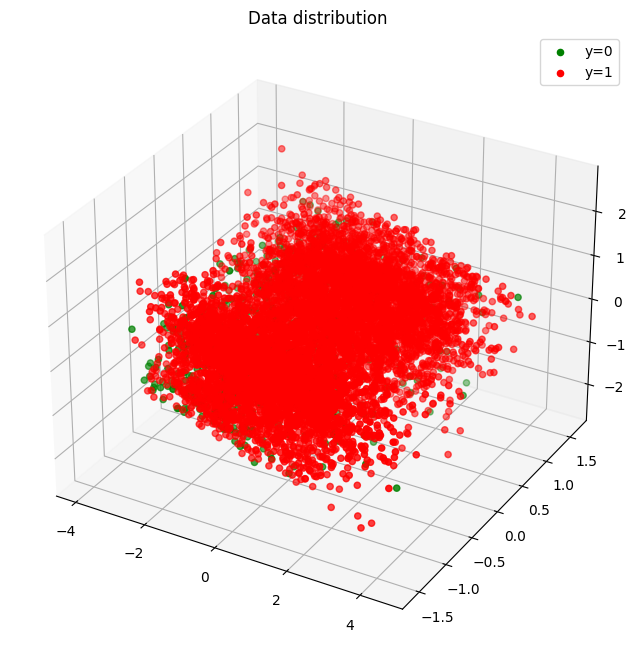

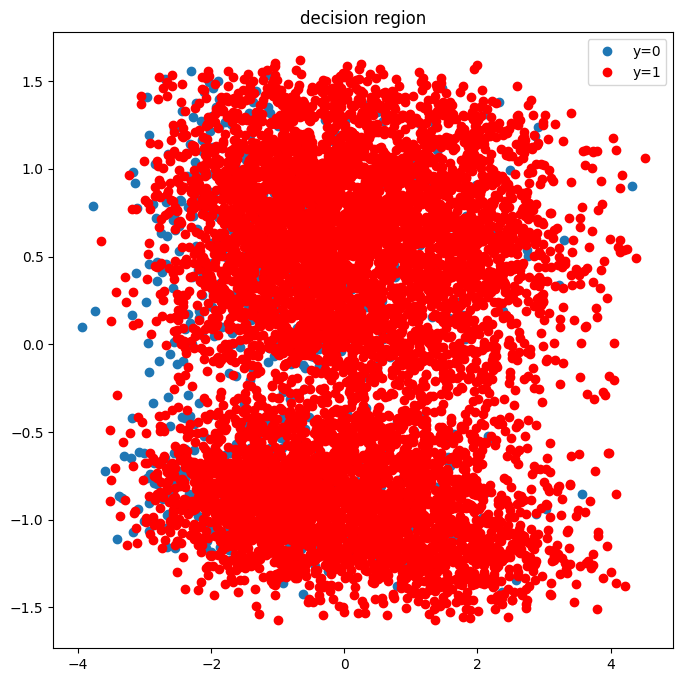

In [75]:
show_data(X, y)
plot_decision_regions_2class(X, y)